## Intro
#### Setup of an experiment
- This notebook is an adaption of the experiment for RQ1, allowing to vary the number of features used in the datasets and investigating the dependency of dataset dimensions.

#### Loading experiments
- run chapter 1 to get the data and generate missing values
- skip chapter 2 (time consuming calculations)
- load outputs saved in output.toml (such as metrics) and reconstructed datasets with:
        output = toml.load("output.toml")
        with open(os.path.join("X_reconstr", 'X_reconstr.pkl'), 'rb') as f:
            X_reconstr = pickle.load(f)
- run chapter 3-5

In [1]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math
import scipy
import astropy.stats
import pickle
import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN

In [3]:
import toml
output_rmse = toml.load("output_rmse.toml")
output_mae = toml.load("output_mae.toml")
output_cml = toml.load("output_cml.toml")
output_kl = toml.load("output_kl.toml")
output_cl = toml.load("output_cl.toml")

with open(os.path.join("X_reconstr_rmse", 'X_reconstr.pkl'), 'rb') as f:
  X_reconstr_rmse = pickle.load(f)
with open(os.path.join("X_reconstr_mae", 'X_reconstr.pkl'), 'rb') as f:
  X_reconstr_mae = pickle.load(f)
with open(os.path.join("X_reconstr_cml", 'X_reconstr.pkl'), 'rb') as f:
  X_reconstr_cml = pickle.load(f)
with open(os.path.join("X_reconstr_kl", 'X_reconstr.pkl'), 'rb') as f:
  X_reconstr_kl = pickle.load(f)
with open(os.path.join("X_reconstr_cl", 'X_reconstr.pkl'), 'rb') as f:
  X_reconstr_cl = pickle.load(f)

## 0. Experiment Setup

In [4]:
# should an output folder be created to save the experiment data?
save_output = False
save_models = False

In [5]:
# read config file
import toml
config = toml.load("config.toml")

# determine experimental parameter from config
experiment_variable_values = ""
experiment_dict_key = ""
for category_name, category_values in config.items():
    if config["general"]["experiment_variable"] in category_values:
        experiment_variable_values = category_values[config["general"]["experiment_variable"]]
        experiment_dict_key = category_name
        
# rnd seed to support reproducable results
def set_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

seed_value =  config["general"]["random_seed"] if config["general"]["random_seed"] else random.randrange(2**32 -1)
seed_train_test_split = config["general"]["seed_train_test_split"] if config["general"]["seed_train_test_split"] else random.sample(range(2**32 -1), config["general"]["models"])
set_seeds(seed_value)

# TabNet hyperparameters
experiment_variable = config["general"]["experiment_variable"]
regressor_param = {"scheduler_params" : {"step_size": 10},
                   "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
                   "mask_type" : 'entmax',
                   "device_name" : 'cuda', # only working on NVIDIA GPUs
                   "seed" : seed_value,
                   "verbose" : 0
                  }

# create experiment folder structure
if save_output or save_models:  
    from datetime import datetime
    
    experiment_name = config["general"]["experiment_name"]
    experiment_folder = f"{datetime.now().strftime('%Y_%m_%d %H-%M-%S')} {experiment_name} " if experiment_name else f"{datetime.now().strftime('%Y_%m_%d %H-%M-%S')} {config['general']['dataset']}-{config['general']['experiment_variable']}-{config['model_param']['eval_metric'][0]}"
    
    experiment_path = os.path.join("04_Experiments", experiment_folder)
    os.mkdir(experiment_path)
    
    plots_path = os.path.join(experiment_path, "plots")
    os.mkdir(plots_path)
    
    models_path = os.path.join(experiment_path, "models")
    os.mkdir(models_path)
    
    X_reconstr_path = os.path.join(experiment_path, "X_reconstr")
    os.mkdir(X_reconstr_path)
    
    # save config file
    import shutil
    shutil.copy2("config.toml", experiment_path)
    config_path = os.path.join(experiment_path, "config.toml")
    
    # save random seeds
    if not config["general"]["random_seed"]:
        config["general"]["random_seed"] = seed_value
        with open(config_path, "w") as f:
            toml.dump(config, f)
    if not config["general"]["seed_train_test_split"]:
        config["general"]["seed_train_test_split"] = seed_train_test_split
        with open(config_path, "w") as f:
            toml.dump(config, f)       
    
    # save model hyperparameters
    with open(os.path.join(experiment_path, 'config.toml'), 'a') as config_file:
        config_file.write("\n#[regressor_param]\n")
        for key, value in regressor_param.items(): 
            config_file.write('#%s = %s\n' % (key, str(value)))
    
    # create output file
    output_path = os.path.join(experiment_path, "output.toml")
    output_file = open(output_path, "w")

output = {}

## 1. Datasets

### 1.0. Choose dataset
Get dataset from config.

In [6]:
from sklearn.preprocessing import scale, StandardScaler

if config["general"]["dataset"] == "wine":
    from sklearn.datasets import load_wine

    dataset = load_wine()
    feature_names = dataset['feature_names']
    X, labels_true = pd.DataFrame(dataset.data, columns=feature_names), dataset.target
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=dataset['feature_names'])
    
elif config["general"]["dataset"] == "iris":
    from sklearn.datasets import load_iris
    
    dataset = load_iris()
    feature_names = dataset['feature_names']
    X, labels_true = pd.DataFrame(dataset.data, columns=feature_names), dataset.target
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=dataset['feature_names'])
    
elif config["general"]["dataset"] == "drybean":
    dataset = pd.read_excel("../../../01_Datasets/Dry_Bean_Dataset.xlsx")
    X = dataset.iloc[:,:-1]
    feature_names = X.columns
    labels_true = np.array(dataset.iloc[:,-1].astype("category").cat.codes)
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    
else:
    raise ValueError(f"The dataset {config['general']['dataset']} is not implemented.")

#### Determine feature distributions
To examine the influence and predictability of outliers, we want to choose a feature of the dataset, that has a distribution including an adequate number of outliers.

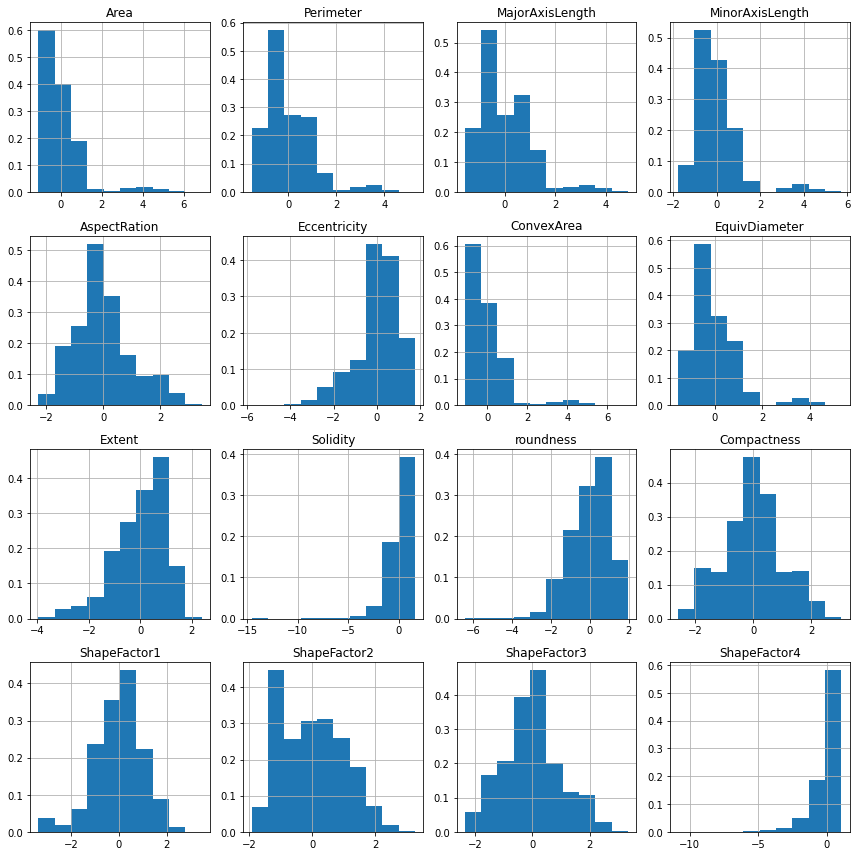

In [7]:
rows = math.ceil(X_scaled.shape[1]/4)
X_scaled.hist(layout=(rows,4), figsize=(12,3*rows), density=True)
plt.tight_layout()
plt.show()

#### Examine outlierness
Examine the number of outliers in both directions. For the given outlier definition (distance to the mean in standard deviations, e.g. 3 * std) the share of outliers in both direction should be large enough.
The outlier definition (x times standard_deviation) is defined in the config.

In [8]:
def n_outliers(data):
    return data[(data < X[experiment_feature].mean() - config["outlier_definition"]["st_deviations"] * X[experiment_feature].std()) | (data > X[experiment_feature].mean() + config["outlier_definition"]["st_deviations"] * X[experiment_feature].std())].count()

In [9]:
def is_outlier(data):
    upper_outlier = data > X[experiment_feature].mean() + config["outlier_definition"]["st_deviations"] * X[experiment_feature].std()
    lower_outlier = data < X[experiment_feature].mean() - config["outlier_definition"]["st_deviations"] * X[experiment_feature].std()
    return (upper_outlier | lower_outlier), lower_outlier, upper_outlier

In [10]:
X_outliers_up = X.agg(lambda x: x[x > x.mean() + config["outlier_definition"]["st_deviations"] * x.std()].count()) / X.shape[0]
X_outliers_low = X.agg(lambda x: x[x < x.mean() - config["outlier_definition"]["st_deviations"] * x.std()].count()) / X.shape[0]

#### Select feature
The selected feature should have at least a certain number of outliers in total and a minimum number of outliers in each direction.

In [11]:
# filter by minimum outliers in each direction
X_outliers_up = X_outliers_up[(X_outliers_up > config["outlier_definition"]["min_outliers_per_direction"]) & (X_outliers_low > config["outlier_definition"]["min_outliers_per_direction"])]
X_outliers_low = X_outliers_low[(X_outliers_up > config["outlier_definition"]["min_outliers_per_direction"]) & (X_outliers_low > config["outlier_definition"]["min_outliers_per_direction"])]

# filter by minimum outliers in total
X_outliers_total = X_outliers_up + X_outliers_low
X_outliers_total = X_outliers_total[X_outliers_total > config["outlier_definition"]["min_outliers_total"]]

# choose the feature with the most equal number of lower/upper outliers
if X_outliers_total.empty:
    raise ValueError("The given dataset does not have a feature fullfilling the required outlier requirements.")
else:
    experiment_feature = abs(X_outliers_up[X_outliers_total.index] - X_outliers_low[X_outliers_total.index]).idxmin()
    output["experiment_feature"] = experiment_feature
    print(f"experiment feature: {experiment_feature}")
    # number of outliers for later use in metrics
    X_n_outliers = n_outliers(X[experiment_feature])
    
    # series of outliers
    std_orig = X[experiment_feature].std()
    mean_orig = X[experiment_feature].mean()
    X_outliers = X[experiment_feature][(X[experiment_feature] < mean_orig - config["outlier_definition"]["st_deviations"] * std_orig) | (X[experiment_feature] > mean_orig + config["outlier_definition"]["st_deviations"] * std_orig)]

experiment feature: Compactness


### 1.1. Create missing data
#### 1.1.1. Create a specified amount of missing values
missing values will be generated for the selected feature in 1.0 as well as for randomly chosen amount of features defined in config --> general --> missing_value_features.

The data will be sampled until at least a certain amount of outliers are replaced by missing values. This enables us to examine the impact of outliers later on.

In [12]:
# create datasets with missing values
X_mv = {}
X_mv_n_outliers = {}

# if the experiment variable is affecting the dataset, we need a dict of the different datasets, else only one dataset named "data"
variable_hyperparams = not config["general"]["experiment_variable"] in ["missing_percent", "missing_outliers", "missing_value_features", "st_deviations", "n_omitted_features"]
X_mv_keys = experiment_variable_values if not variable_hyperparams else [experiment_variable]

# for RQ2 (experiment_variable = missing_value_features), we use the same missing values for all experiment_values (this should maybe be done generally for all experiment_variables)
sample_seed = random.sample(range(2**32 -1), config["general"]["runs"])

for experiment_value in X_mv_keys:

    if not variable_hyperparams:
        config[experiment_dict_key][config["general"]["experiment_variable"]] = experiment_value

    n_outliers_req = round(config["general"]["missing_outliers"] * X_n_outliers)
    n_outliers_generated = round(config["general"]["missing_percent"] * len(X))
    if n_outliers_generated < n_outliers_req:
        raise ValueError("The ratio of missing values created has to be larger than than the required ratio of outlier-missing-values. Increase 'missing percent' or decrease 'missing_outliers' before proceeding.")

    X_mv[experiment_value] = []
    X_mv_n_outliers[str(experiment_value)] = []
    
    for run in range(config["general"]["runs"]):
        
        # select % of features to use for predictions, defined in config: n_omitted_features (e.g. 10% of randomly selected features)
        n_omitted_features = math.floor(config["RQ2"]["n_omitted_features"] * (len(X.columns) - 1))
        n_used_features = max(1, (len(X.columns) - 1 - n_omitted_features)) # experiment_feature not counted
        used_features = list(X.copy().drop(experiment_feature, axis=1).sample(n=n_used_features, axis='columns').columns)
        used_features.append(experiment_feature)
        
        # create missing values in feature column(s) and assure, that at least x% of missing values were outliers
        n_mv_features = round(len(used_features)*experiment_value) if experiment_variable == "missing_value_features" else round(len(used_features)*config["general"]["missing_value_features"]) # if clause useless?
        rnd_features = random.sample([n for n in used_features if n != experiment_feature], n_mv_features)
        mv_config = {feature:config["general"]["missing_percent"] for feature in rnd_features}

        if run == 0 or experiment_variable != "missing_value_features":
            # remove at least n_outliers_req outliers
            X_mv[experiment_value].append(X[used_features].copy())
            
            _, l_outliers, u_outliers = is_outlier(X_mv[experiment_value][run][experiment_feature])
            sample_upper_outliers = X_mv[experiment_value][run][experiment_feature][u_outliers].sample(math.floor(n_outliers_req / 2), random_state = sample_seed[run])
            sample_lower_outliers = X_mv[experiment_value][run][experiment_feature][l_outliers].sample(math.ceil(n_outliers_req / 2), random_state = sample_seed[run])
            sample_rest = X_mv[experiment_value][run][experiment_feature].sample(n_outliers_generated - n_outliers_req, random_state = sample_seed[run])
            
            X_mv[experiment_value][run].loc[sample_rest.index.union(sample_lower_outliers.index).union(sample_upper_outliers.index),experiment_feature] = np.nan
            
        else:
            # use same experiment_feature mvs for all runs, only vary other missing features
            X_mv[experiment_value].append(X_mv[X_mv_keys[0]][0].copy())
  
        # remove values in other features
        for f, mv in mv_config.items():
            X_mv[experiment_value][run][f] = X_mv[experiment_value][run][f].mask(np.random.random(len(X)) < mv)

        # calculate share of outliers in sample
        mvs = X[experiment_feature][X_mv[experiment_value][run][experiment_feature].isna()]
        X_mv_n_outliers[str(experiment_value)].append(n_outliers(mvs))

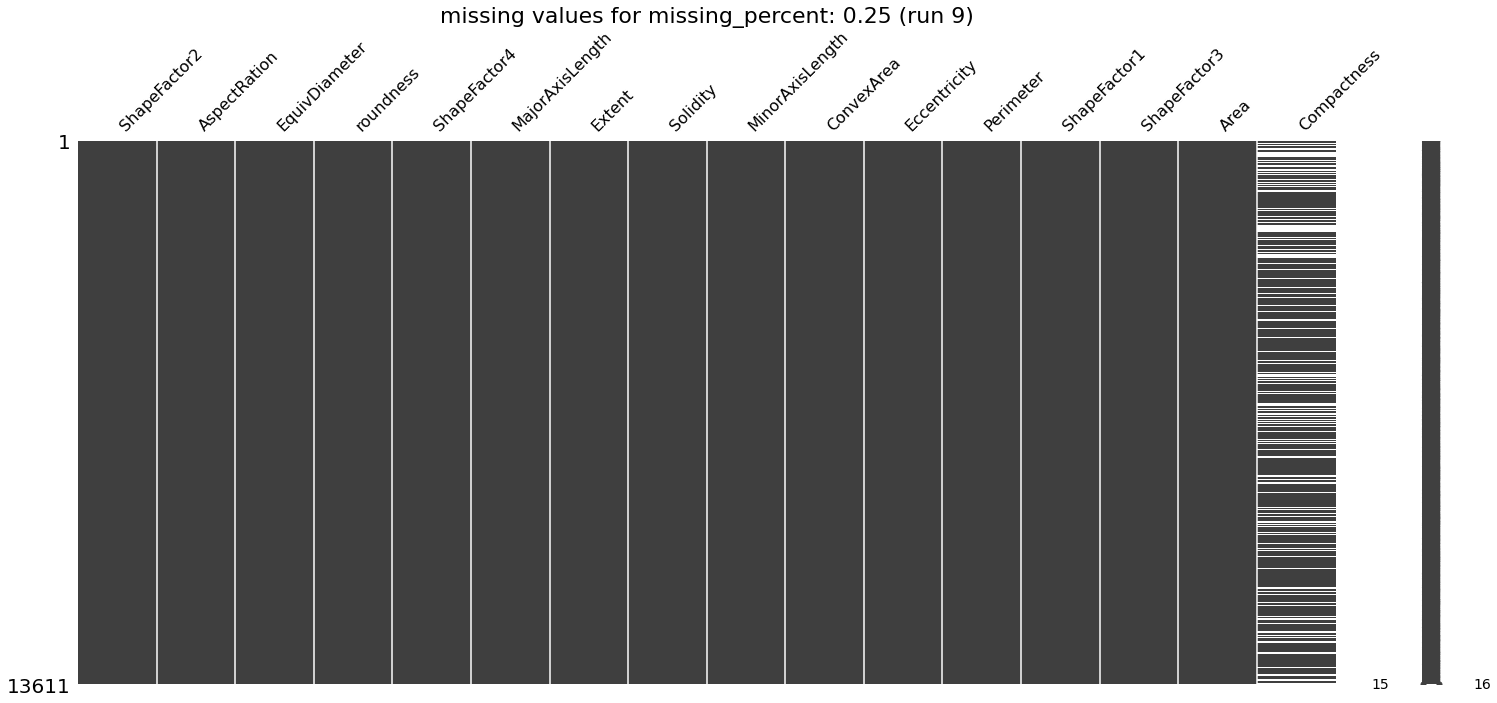

In [13]:
import missingno as msno
%matplotlib inline

# plot missing values
fig = msno.matrix(X_mv[experiment_value][run])
plt.title(f"missing values for {experiment_variable}: {experiment_value} (run {run})", fontsize=22)
plt.show()
if save_output:
    fig_copy = fig.get_figure()
    fig_copy.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"], bbox_inches = 'tight')

#### 1.1.2. Save outlier numbers to output

In [14]:
output["n_outliers"] = {}
output["n_outliers"]["X"] = X_n_outliers
output["n_outliers"]["X_mv"] = X_mv_n_outliers

#### 1.1.3. Distribution after removing random values

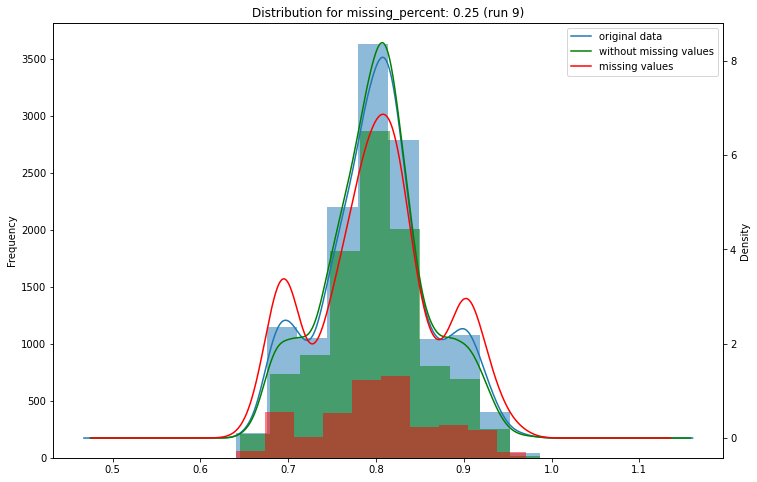

In [15]:
mv = X.copy()[X_mv[experiment_value][run][experiment_feature].isna()]

fig, ax = plt.subplots(figsize=(12,8))
X[experiment_feature].plot.hist(ax=ax, alpha=0.5)
X_mv[experiment_value][run][experiment_feature].plot.hist(ax=ax, alpha=0.5, color='green')
mv[experiment_feature].plot.hist(ax=ax, alpha=0.5, color='red')

ax2 = ax.twinx()
X[experiment_feature].plot.kde(ax=ax2)
X_mv[experiment_value][run][experiment_feature].plot.kde(ax=ax2, color='green')
mv[experiment_feature].plot.kde(ax=ax2, color='red')
plt.title(f"Distribution for {experiment_variable}: {experiment_value} (run {run})")
plt.legend(['original data', 'without missing values', 'missing values'])

plt.show()

#### 1.1.3. Kurtosis
If the data is sufficiently close to a normal distribution, the Kurtosis measure could be used to compare the tailedness of the data before and after predictions. This does, however not necessarily apply for the given feature.

In [16]:
scipy.stats.kurtosistest(X_mv[experiment_value][run][X_mv[experiment_value][run][experiment_feature].notna()][experiment_feature])

KurtosistestResult(statistic=-2.1291892746456202, pvalue=0.03323860390823513)

### 1.3. Initial Clustering (without missing values)

#### 1.3.1 DBSCAN (for wine dataset)
Generel problem with DBSCAN: curse of dimensionality for datasets with high feature counts.

Automatically determine DBSCAN hyperparameters min_samples and eps.\
min_samples results in 26 for the wine dataset (dimensionality 13).\
for eps we choose 2.5 (elbow of the graph).

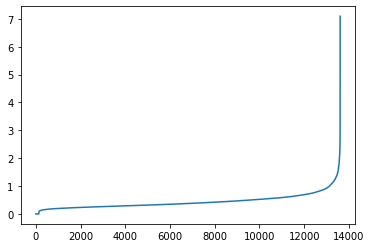

In [17]:
from sklearn.neighbors import NearestNeighbors

min_samples = 2 * len(X_scaled.columns)

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Use the cluster algorithm on dataset without missing values shows, that DBSCAN is not performaing well with 13 dimensional dataset (curse of dimensionality leads to either 1 or 0 clusters).

In [18]:
# run DBSCAN on original data
config["DBSCAN"]["eps"] = 1
config["DBSCAN"]["min_samples"] = min_samples

if save_output or save_models:
    config[experiment_dict_key][config["general"]["experiment_variable"]] = experiment_variable_values
    with open(config_path, "w") as f:
        toml.dump(config, f)
        
dbscan_orig = DBSCAN(**config["DBSCAN"]).fit(X_scaled)
labels_orig = dbscan_orig.labels_
print(f"DBSCAN noise: {(sum(abs(labels_orig[labels_orig == -1]))*100) / len(labels_true)}%")
print(f"DBSCAN clusters: {np.unique(labels_orig)}")

DBSCAN noise: 14.069502608184557%
DBSCAN clusters: [-1  0  1]


#### 1.3.2 K-Means
As an alternative, we use k-means for the initial clustering (k=3). This does clearly work better with a more than 96% correct labeling of data.

In [19]:
from sklearn.cluster import KMeans
k_mean_orig = KMeans(n_clusters=len(np.unique(labels_true)), random_state=seed_value).fit(X_scaled)
labels_orig = k_mean_orig.labels_

Using munkres/hungarian algorithm to allign the k-means cluster names with the original cluster means.\
Source: https://gist.github.com/siolag161/dc6e42b64e1bde1f263b

In [20]:
from munkres import Munkres
from sklearn.metrics import confusion_matrix

# use Munkres / Hungarian algorithm to relabel clusters in order to match original label names
def make_cost_matrix(c1, c2):
    """
    """
    uc1 = np.unique(c1)
    uc2 = np.unique(c2)
    l1 = uc1.size
    l2 = uc2.size
    #if not (l1 == l2 and np.all(uc1 == uc2)):
    #    raise ValueError(f"Clustering could not detect the correct number of clusters (k={len(uc2)})")

    m = np.ones([l1, l2])
    for i in range(l1):
        it_i = np.nonzero(c1 == uc1[i])[0]
        for j in range(l2):
            it_j = np.nonzero(c2 == uc2[j])[0]
            m_ij = np.intersect1d(it_j, it_i)
            m[i,j] =  -m_ij.size
    return m

In [21]:
cost_matrix = make_cost_matrix(labels_orig, labels_true)
indexes = Munkres().compute(cost_matrix)
mapping = [new for (_, new) in indexes]
labels_orig_renamed = np.choose(labels_orig, mapping).astype(np.int64)

mislabeled = labels_true - labels_orig_renamed
mislabeled[mislabeled != 0] = 1
mislabeled_orig = sum(mislabeled) / len(mislabeled)
print(f"{round(mislabeled_orig * 100, 2)}% mislabeled")

21.35% mislabeled


Get cluster means for loss function input.

In [22]:
# get cluster means (used to calculate the cluster mean loss)
complete_data = X.copy()
complete_data["C"] = labels_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies
Applying different imputation strategies to the incomplete dataset.

### 2.1. Define custom-loss
The loss function for the model fitting shall be customized to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.
3. **KL Divergence Loss**\
Deviation of original distribution shall be minimized \
(prob distribution based on https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula \
number of bins: D. Freedman & P. Diaconis (1981) “On the histogram as a density estimator: L2 theory”. Probability Theory and Related Fields 57 (4): 453-476)

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [23]:
# define custom loss function: extend L2-loss by cluster-mean-loss and KL divergence

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, y_name, x_val, y_val, cl_weights = [0.5, 1, 0.0001]):
        # reconstruction loss
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        
        # cluster mean loss
        cml = 0 if cl_weights[2] == 0 else self.cluster_mean_loss(cluster_means, y_score, y_name, x_val, y_val)
        
        # KL divergence loss
        # - range of values
        min_val = min(min(y_true[:,0]), min(y_score[:,0]))
        max_val = max(max(y_true[:,0]), max(y_score[:,0]))
        # - prob. density function
        distr_pred = scipy.stats.gaussian_kde(y_score[:,0]).evaluate(np.linspace(min_val,max_val,100)) + sys.float_info.min
        distr_true = scipy.stats.gaussian_kde(y_true[:,0]).evaluate(np.linspace(min_val,max_val,100)) + sys.float_info.min
        # - calc. KL divergence on normalized pdf
        KLdl = torch.nn.functional.kl_div((torch.tensor(distr_pred/sum(distr_pred))).log(), torch.tensor(distr_true/sum(distr_true)), log_target=False, reduction='sum').item()
        
        # total loss
        custom_loss = cl_weights[0] * rmse + cl_weights[1] * KLdl + cl_weights[2] * cml
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, y_name, x_val, y_val):
        
        # reorder cluster_means to match x_val columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = X.columns.get_loc(y_name)
        cols = cols[:feature_col] + cols[feature_col+1:] + [y_name]
        
        # x values extended by predicted values
        x_extended = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster in range(cluster_means.shape[0]):
            dist.append(np.linalg.norm((x_extended - cluster_means.iloc[cluster]), axis=1))
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(min_dist)

### 2.2. Fill missing values (TabNet)

In general, we want to train a fixed (see config) number of models and make predictions on all datasets. The final prediction value will be the median value of all trained models. The median is used here, as it has shown, that most models will have a similar prediction performance, but some "bad" model outliers with significantly worse performance can occur.

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
This way the amount of required models can be reduced and the model can learn correlations from the presence of missing values. However we cannot expect an improvement from learning correlations when the missing data is MCAR, as "missing values (MCAR) are interpreted as a random reduction of the dataset, which provide no further information for assigning incomplete feature
vectors to clusters." (H. Timm, et al., "Different approaches to fuzzy clustering of incomplete datasets")\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

**Approach 3:**
To further reduce the number of trained models and in order to focus on features with an appropriate number of outliers: only predict and examine one feature (see chosen feature above) and leave the others with their masked values.\
&rarr; Problem: missing value mask of other features impacts the subsequent clustering. Additionally, due to the MCAR missing value generation for the used datasets, there is no useful information in the missing values of other features. Thus, the model cannot learn anything from the masked values. It does however make sense to implement it this way for further research of real incomplete datasets.\
As we are interested in the predictive performance of the experiment feature, a solution to the subsequent clustering problem is, to reconstruct the other features with their original values (i.e. the predictions are based on the incomplete dataset, but the clustering will be based on the predicted feature plus the original other features).

In [ ]:
import time

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

X_reconstr = {}
X_reconstr["TabNet"] = {}
output["costs"] = {}
output["runtimes"] = {}
output["predictions"] = {}
all_models = {}

for i, experiment_value in enumerate(experiment_variable_values):
    
    X_reconstr["TabNet"][str(experiment_value)] = []
    output["costs"][str(experiment_value)] = {}
    output["runtimes"][str(experiment_value)] = {}
    output["predictions"][str(experiment_value)] = {}
    all_models[experiment_value] = []
    
    config[experiment_dict_key][config["general"]["experiment_variable"]] = experiment_value
    ds_name = experiment_variable if variable_hyperparams else experiment_value
    
    for run in range(config["general"]["runs"]):
        
        print(f"{i*config['general']['runs'] + run} / {len(experiment_variable_values) * config['general']['runs']} --------------------------------------------------")
        
        output["costs"][str(experiment_value)][f"run_{run}"] = {}
        output["runtimes"][str(experiment_value)][f"run_{run}"] = {}
        output["predictions"][str(experiment_value)][f"run_{run}"] = {}   
        
        time_start = time.time()
        
        X_reconstr["TabNet"][str(experiment_value)].append(X.copy())
        X_reconstr["TabNet"][str(experiment_value)][run][experiment_feature] = X_mv[X_mv_keys[0]][run][experiment_feature] if variable_hyperparams else X_mv[experiment_value][run][experiment_feature]

        # mask non-experiment_feature missing values as defined in config (missing_value_mask)
        predictive_features = X_mv[ds_name][run].copy().drop(experiment_feature, axis=1).columns
        X_mv_masked = X_mv[ds_name][run].copy()
        X_mv_masked[predictive_features] = X_mv_masked[predictive_features].fillna(config["general"]["missing_value_mask"])

        # separate complete rows as train data
        # separate column with missing values as target
        test_data = X_mv_masked[X_mv_masked[experiment_feature].isna()].drop(experiment_feature, axis=1).to_numpy()
        train_data = X_mv_masked[X_mv_masked[experiment_feature].notna()]
        train_features = train_data.drop(columns=experiment_feature).to_numpy()
        train_target = train_data[experiment_feature].to_numpy().reshape(-1,1)
        
        models = []
        for model in range(config["general"]["models"]):

            x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, train_size=config["training"]["train_val_split"], random_state = seed_train_test_split[model])
                
            # create & train model
            tabnet_model = TabNetRegressor(**regressor_param)
            if config["model_param"]["eval_metric"] == ["custom_loss"]:
                tabnet_model.fit(
                    x_train, y_train,
                    eval_set=[(x_val, y_val)],
                    **config["model_param"],
                    cluster_means=cluster_means,
                    y_name=experiment_feature,
                    x_val=x_val,
                    y_val=y_val,
                    cl_weights=config["training"]["cl_weights"]
                )
            else:
                tabnet_model.fit(
                    x_train, y_train,
                    eval_set=[(x_val, y_val)],
                    **config["model_param"]
                )
                
            models.append(tabnet_model)
        
        # chose model based on minimum costs
        model_costs = [m.best_cost for m in models]
        best_model = models[model_costs.index(min(model_costs))]
        all_models[experiment_value].append(best_model)
        
        # save costs
        output["costs"][str(experiment_value)][f"run_{run}"] = float(best_model.best_cost)

        # save predictions
        predictions = [x[0] for x in best_model.predict(test_data)]
        output["predictions"][str(experiment_value)][f"run_{run}"] = predictions

        # fill missing values with model predictions
        X_reconstr["TabNet"][str(experiment_value)][run].loc[X_reconstr["TabNet"][str(experiment_value)][run][experiment_feature].isna(), experiment_feature] = predictions

        # save models
        if save_models:
            torch.save(best_model, os.path.join(models_path, f"Model_{config['general']['experiment_variable']}{experiment_value}_run_{run}.pt"))            

        #track runtime
        time_end = time.time()
        output["runtimes"][str(experiment_value)][f"run_{run}"] = time_end - time_start

0 / 50 --------------------------------------------------

Early stopping occurred at epoch 115 with best_epoch = 65 and best_val_0_mae = 0.58556
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_mae = 0.31871
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 174 with best_epoch = 124 and best_val_0_mae = 0.41273
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_mae = 0.33476
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 128 with best_epoch = 78 and best_val_0_mae = 1.96949
Best weights from best epoch are automatically used!
1 / 50 --------------------------------------------------
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_mae = 0.51721
Best weights from best epoch are automatically u


Early stopping occurred at epoch 174 with best_epoch = 124 and best_val_0_mae = 0.41273
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_mae = 0.33476
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 128 with best_epoch = 78 and best_val_0_mae = 1.96949
Best weights from best epoch are automatically used!
11 / 50 --------------------------------------------------
Stop training because you reached max_epochs = 250 with best_epoch = 217 and best_val_0_mae = 0.41026
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_mae = 0.46379
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 248 and best_val_0_mae = 0.38265
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 

### 2.2. Fill missing values (Heuristic Imputation - mean)
Replacing missing values by a heuristic (such as the mean) of their respective feature.

In [ ]:
# update X_reconstr. when loading older experiments ("Heuristic" and "Multivariate" were renamed)
_ = X_reconstr.pop("Heuristic") if "Heuristic" in X_reconstr else None
_ = X_reconstr.pop("Multivariate") if "Multivariate" in X_reconstr else None

In [ ]:
from sklearn.impute import SimpleImputer

X_reconstr["Mean_substitution"] = {}

for experiment_value in X_mv_keys:
    X_reconstr["Mean_substitution"][experiment_value] = []
    for run in range(config["general"]["runs"]):
        X_temp = X.copy()
        X_temp[experiment_feature] = X_mv[experiment_value][run][experiment_feature]
        X_reconstr["Mean_substitution"][experiment_value].append(pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_temp), columns=feature_names))

### 2.3. Fill missing values (Regression Imputation)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X_reconstr["Regression"] = {}
for experiment_value in X_mv_keys:
    X_reconstr["Regression"][experiment_value] = []
    for run in range(config["general"]["runs"]):
        X_temp = X.copy()
        X_temp[experiment_feature] = X_mv[experiment_value][run][experiment_feature]
        X_reconstr["Regression"][experiment_value].append(pd.DataFrame(IterativeImputer(max_iter=10, random_state=seed_value).fit_transform(X_temp), columns=feature_names))

Save reconstructed datasets

In [ ]:
if save_output:
    with open(os.path.join(X_reconstr_path, 'x_reconstr.pkl'), 'wb') as f:
        pickle.dump(X_reconstr, f)

## 3. Reconstruct Dataset
choose best TabNet model based model loss.

In [ ]:
best_runs = [min(values.values()) for run, values in output["costs"].items()]
best_runs_index = [list(values.values()).index(min(values.values())) for run, values in output["costs"].items()]
    
best_experiment_value_index = best_runs.index(min(best_runs))
best_experiment_value = experiment_variable_values[best_experiment_value_index]
best_run = best_runs_index[best_experiment_value_index]

print(f"Best model: run {best_run} for {experiment_variable} {best_experiment_value}")

X_best = X_reconstr["TabNet"][str(best_experiment_value)][best_run]

## 4. Clustering
Apply k-means (k=3) on reconstructed data. In order to make the clusters comparable, the k-Means labels will be replaced using Munkres / Hungarian algorithm as explained here:\
https://gist.github.com/siolag161/dc6e42b64e1bde1f263b \
https://github.com/benchaplin/hungarian-algorithm

### 4.1. TabNet

In [23]:
labels_reconstr_tabnet = {}
losses = ['rmse', 'mae', 'cml', 'kl', 'cl']
for loss in losses:
    labels_reconstr_tabnet[loss] = []
    X_reconstr = eval(f"X_reconstr_{loss}")
    
    for i, experiment_value in enumerate(experiment_variable_values):
        
        labels_reconstr_tabnet[loss].append([])

        for run in range(config["general"]["runs"]):
            X_reconstr_scaled = pd.DataFrame(StandardScaler().fit_transform(X_reconstr["TabNet"][str(experiment_value)][run]))
            k_mean_reconstr = KMeans(n_clusters=len(np.unique(labels_true))).fit(X_reconstr_scaled)

            cost_matrix = make_cost_matrix(k_mean_reconstr.labels_, labels_true)
            indexes = Munkres().compute(cost_matrix)
            mapping = [new for (_, new) in indexes]

            labels_reconstr_tabnet[loss][i].append(np.choose(k_mean_reconstr.labels_,mapping).astype(np.int64))

### 4.2. Mean Substitution

In [24]:
labels_reconstr_mean_sub = []

for i, experiment_value in enumerate(X_mv_keys):

    labels_reconstr_mean_sub.append([])
    
    for run in range(config["general"]["runs"]):
        X_reconstr_scaled = pd.DataFrame(StandardScaler().fit_transform(X_reconstr["Mean_substitution"][experiment_value][run]))
        k_mean_reconstr = KMeans(n_clusters=len(np.unique(labels_true))).fit(X_reconstr_scaled)

        cost_matrix = make_cost_matrix(k_mean_reconstr.labels_, labels_true)
        indexes = Munkres().compute(cost_matrix)
        mapping = [new for (_, new) in indexes]

        labels_reconstr_mean_sub[i].append(np.choose(k_mean_reconstr.labels_,mapping).astype(np.int64))

### 4.3. Regression Imputation

In [25]:
labels_reconstr_regression = []

for i, experiment_value in enumerate(X_mv_keys):

    labels_reconstr_regression.append([])
    
    for run in range(config["general"]["runs"]):
        X_reconstr_scaled = pd.DataFrame(StandardScaler().fit_transform(X_reconstr["Regression"][experiment_value][run]))
        k_mean_reconstr = KMeans(n_clusters=len(np.unique(labels_true))).fit(X_reconstr_scaled)

        cost_matrix = make_cost_matrix(k_mean_reconstr.labels_, labels_true)
        indexes = Munkres().compute(cost_matrix)
        mapping = [new for (_, new) in indexes]

        labels_reconstr_regression[i].append(np.choose(k_mean_reconstr.labels_,mapping).astype(np.int64))

## 5. Cluster Performance
Performance metrics to measure distribution preservance and cluster performance
### 5.1 Feature Distributions
Quality / Performance of distribution preservance
#### 5.1.1 Distr. Plot based on best model's predictions
Plot distribution (changes) using the lowest cost TabNet model.

In [ ]:
# get max values to determine common scale
y1, _, _ = plt.hist(X[experiment_feature])
y2, _, _ = plt.hist(X_best[experiment_feature])

ds_name = experiment_variable if variable_hyperparams else best_experiment_value

mv = X.copy()[X_mv[ds_name][best_run][experiment_feature].isna()]
y3, _, _ = plt.hist(mv[experiment_feature])

data_regression = X_reconstr["Regression"][ds_name][best_run][experiment_feature]
y4, _, _ = plt.hist(data_regression)

data_mean_sub = X_reconstr["Mean_substitution"][ds_name][best_run][experiment_feature]
y5, _, _ = plt.hist(data_mean_sub)

y_max = max([y1.max(), y2.max(), y3.max(), y4.max(), y5.max()]) * 1.5
x_max = max(X[experiment_feature].max(), X_best[experiment_feature].max(), data_regression.max(), data_mean_sub.max()) * 1.2
x_min = min(X[experiment_feature].min(), X_best[experiment_feature].min(), data_regression.min(), data_mean_sub.min()) * 0.8

fontsize = 12

plt.close()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(18,8))
# Frequencies

X[experiment_feature].plot.hist(ax=axs[0], alpha=0.6, color='gray', label='original distribution')
X_best[experiment_feature].plot.hist(ax=axs[0], alpha=0.4, color='m', label='lowest cost TabNet imputation')
mv[experiment_feature].plot.hist(ax=axs[0], alpha=1, color='r', label='removed values')
axs[0].set_title(f"TabNet ({config['model_param']['eval_metric'][0]}) Imputation", fontsize=fontsize)
axs[0].set_ylim([0, y_max])

X[experiment_feature].plot.hist(ax=axs[1], alpha=0.6, color='gray')
data_regression.plot.hist(ax=axs[1], alpha=0.4, color='b', label='Regression imputation')
mv[experiment_feature].plot.hist(ax=axs[1], alpha=1, color='r')
axs[1].get_yaxis().set_visible(False)
axs[1].set_title("Regression Imputation",fontsize=fontsize)
axs[1].set_ylim([0, y_max])

X[experiment_feature].plot.hist(ax=axs[2], alpha=0.6, color='gray')
data_mean_sub.plot.hist(ax=axs[2], alpha=0.4, color='g', label='Mean substitution')
mv[experiment_feature].plot.hist(ax=axs[2], alpha=1, color='r')
axs[2].get_yaxis().set_visible(False)
axs[2].set_title("Mean Substitution",fontsize=fontsize)
axs[2].set_ylim([0, y_max])

# Densities

ax1 = axs[0].twinx()
X[experiment_feature].plot.kde(ax=ax1, color='k', linewidth=2.5)
X_best[experiment_feature].plot.kde(ax=ax1, color='m', linewidth=2.5)
ax1.get_yaxis().set_visible(False)
ax1.set_xlim([x_min, x_max])
_, ymax1 = ax1.get_ylim()
#mv[experiment_feature].plot.kde(ax=ax2, color='red')

ax2 = axs[1].twinx()
X[experiment_feature].plot.kde(ax=ax2, color='k', linewidth=2.5)
data_regression.plot.kde(ax=ax2, color='b', linewidth=2.5)
ax2.get_yaxis().set_visible(False)
ax2.set_xlim([x_min, x_max])
_, ymax2 = ax2.get_ylim()

ax3 = axs[2].twinx()
X[experiment_feature].plot.kde(ax=ax3, color='k', linewidth=2.5)
data_mean_sub.plot.kde(ax=ax3, color='g', linewidth=2.5)
ax3.set_xlim([x_min, x_max])
_, ymax3 = ax3.get_ylim()
ymax = max([ymax1, ymax2, ymax3])

ax1.set_ylim([0, ymax])
ax2.set_ylim([0, ymax])
ax3.set_ylim([0, ymax])

plt.suptitle(f"Lowest cost reconstructed distribution\n({config['general']['experiment_variable']} = {best_experiment_value})",fontsize=20)

if save_output:
    plt.savefig(os.path.join(plots_path, "5_distributions.png"), **config["plots"])

lines_labels = [fig.axes[0].get_legend_handles_labels(), ([fig.axes[1].get_legend_handles_labels()[0][1]], [fig.axes[1].get_legend_handles_labels()[1][1]]), ([fig.axes[2].get_legend_handles_labels()[0][1]], [fig.axes[2].get_legend_handles_labels()[1][1]])]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=10, fontsize=fontsize)
plt.tight_layout()  
plt.show()

## 5.1.2 KL Divergence
Calculate the KL divergence using the normalized (sum=1) probability density function as input.

In [26]:
# KL Divergence
def kl_divergence(d_pred, d_true):
    min_val = min(min(d_pred), min(d_true))
    max_val = max(max(d_pred), max(d_true))
    
    distr_pred = scipy.stats.gaussian_kde(d_pred).evaluate(np.linspace(min_val,max_val,100)) + sys.float_info.min
    distr_true = scipy.stats.gaussian_kde(d_true).evaluate(np.linspace(min_val,max_val,100)) + sys.float_info.min

    return torch.nn.functional.kl_div(torch.tensor(distr_pred/sum(distr_pred)).log(), torch.tensor(distr_true/sum(distr_true)), log_target=False, reduction='sum').item()

Save KL divergence to output.

In [27]:
kl_divs = {}

for loss in losses:
    X_reconstr = eval(f"X_reconstr_{loss}")
    kl_divs[loss] = {}
    kl_divs[loss]["Mean_substitution"] = {}
    kl_divs[loss]["Regression"] = {}
    kl_divs[loss]["TabNet"] = {}

    for experiment_value in X_mv_keys:    
        kl_divs[loss]["Mean_substitution"][str(experiment_value)] = {}
        kl_divs[loss]["Regression"][str(experiment_value)] = {}

        for run in range(config["general"]["runs"]):
            kl_divs[loss]["Mean_substitution"][str(experiment_value)][f"run_{run}"] = kl_divergence(X_reconstr["Mean_substitution"][experiment_value][run][experiment_feature], X[experiment_feature])
            kl_divs[loss]["Regression"][str(experiment_value)][f"run_{run}"] = kl_divergence(X_reconstr["Regression"][experiment_value][run][experiment_feature], X[experiment_feature])



    for i, experiment_value in enumerate(experiment_variable_values):    
        kl_divs[loss]["TabNet"][str(experiment_value)] = {}

        for run in range(config["general"]["runs"]):
            kl_divs[loss]["TabNet"][str(experiment_value)][f"run_{run}"] = kl_divergence(X_reconstr["TabNet"][str(experiment_value)][run][experiment_feature], X[experiment_feature])

Create KL divergence plot.

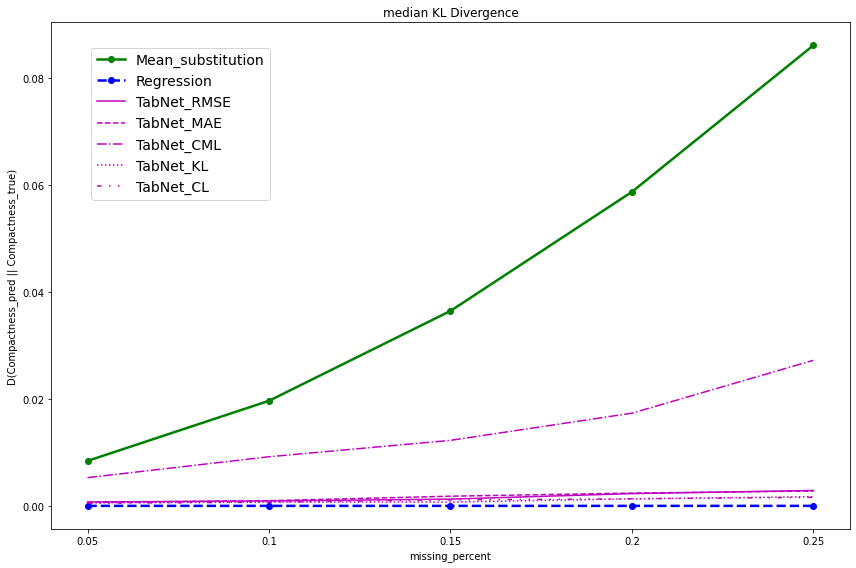

In [28]:
# plot
data = {}
for loss in losses:
    data[loss] = {}
    data[loss]["Mean_substitution"] = {k: list(v.values()) for k,v in kl_divs[loss]["Mean_substitution"].items()}
    data[loss]["Regression"] = {k: list(v.values()) for k,v in kl_divs[loss]["Regression"].items()}
    data[loss]["TabNet"] = {k: list(v.values()) for k,v in kl_divs[loss]["TabNet"].items()}

fig, ax = plt.subplots(figsize = (12,8))

if variable_hyperparams:
    plt.axhline(y=[np.median(x) for x in data['rmse']["Mean_substitution"].values()], color='g', linestyle='-', linewidth=2.5)
    plt.axhline(y=[np.median(x) for x in data['rmse']["Regression"].values()], color='b', linestyle='--', linewidth=2.5)
else:
    ax.errorbar(x = list(data['rmse']["Mean_substitution"].keys()), y = [np.median(x) for x in data['rmse']["Mean_substitution"].values()], linestyle='-', color = 'g', linewidth=2.5, fmt='o', capsize=10)
    ax.errorbar(x = list(data['rmse']["Regression"].keys()), y = [np.median(x) for x in data['rmse']["Regression"].values()],linestyle='--',  ecolor='b', color = 'b', linewidth=2.5, fmt='o', capsize=10)

ax.errorbar(x = list(data['rmse']["TabNet"].keys()), y = [np.median(x) for x in data['rmse']["TabNet"].values()], linestyle='-', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['mae']["TabNet"].keys()), y = [np.median(x) for x in data['mae']["TabNet"].values()], linestyle='--', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['cml']["TabNet"].keys()), y = [np.median(x) for x in data['cml']["TabNet"].values()], linestyle='-.', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['kl']["TabNet"].keys()), y = [np.median(x) for x in data['kl']["TabNet"].values()], linestyle=':', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['cl']["TabNet"].keys()), y = [np.median(x) for x in data['cl']["TabNet"].values()], linestyle=(0, (3, 5, 1, 5, 1, 5)), ecolor='m', color = 'm', linewidth=1.5, capsize=10)




plt.xlabel(f"{config['general']['experiment_variable']}")
plt.ylabel(f"D({experiment_feature}_pred || {experiment_feature}_true)")
plt.title("median KL Divergence")
plt.legend(['Mean_substitution', 'Regression', 'TabNet_RMSE', 'TabNet_MAE', 'TabNet_CML', 'TabNet_KL', 'TabNet_CL'],fontsize=14, loc=(0.05, 0.65))

plt.tight_layout() 

if save_output:
    plt.savefig(os.path.join(plots_path, "5_kl_divergence.png"), **config["plots"])
    plt.show()

#### 5.1.2 Share of correctly predicted outliers
To examine the quality of the outlier predictions, we take the prediction values of the (original) outliers and check, if they would be outliers in the **original** distribution.

In [33]:
X_mv_outliers = {}
n_outliers = {}

for loss in losses:
    X_reconstr = eval(f"X_reconstr_{loss}")
    n_outliers[loss] = {}
    n_outliers[loss]["Mean_substitution"] = {}
    n_outliers[loss]["Regression"] = {}
    n_outliers[loss]["TabNet"] = {}
    

    for experiment_value in X_mv_keys:
        X_mv_outliers[experiment_value] = []
        n_outliers[loss]["Mean_substitution"][str(experiment_value)] = {}
        n_outliers[loss]["Regression"][str(experiment_value)] = {}

        for run in range(config["general"]["runs"]):

            # indices of removed outliers (missing values)
            X_mv_outliers[experiment_value].append(X_mv[experiment_value][run][experiment_feature][X_mv[experiment_value][run][experiment_feature].isna()].index.intersection(X_outliers.index))

            # check if the predicted values are outsiders in the original distribution
            x = X_reconstr["Mean_substitution"][experiment_value][run][experiment_feature].iloc[X_mv_outliers[experiment_value][run]]
            x_outliers, _, _ = is_outlier(x)
            n_outliers[loss]["Mean_substitution"][str(experiment_value)][f"run_{run}"] = x_outliers.sum()

            x = X_reconstr["Regression"][experiment_value][run][experiment_feature].iloc[X_mv_outliers[experiment_value][run]]
            x_outliers, _, _ = is_outlier(x)
            n_outliers[loss]["Regression"][str(experiment_value)][f"run_{run}"] = x_outliers.sum()


    for i, experiment_value in enumerate(experiment_variable_values):
        n_outliers[loss]["TabNet"][str(experiment_value)] = {}

        for run in range(config["general"]["runs"]):

            x = X_reconstr["TabNet"][str(experiment_value)][run][experiment_feature].iloc[X_mv_outliers[experiment_variable if variable_hyperparams else experiment_value][run]]
            x_outliers, _, _ = is_outlier(x)
            n_outliers[loss]["TabNet"][str(experiment_value)][f"run_{run}"] =  x_outliers.sum()

Create plot of outlier prediction quality.

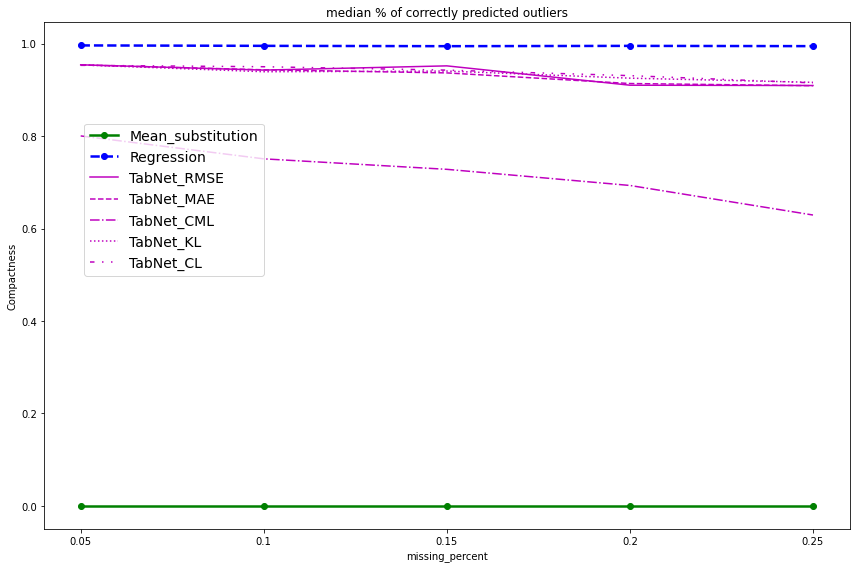

In [34]:
# share of outliers
data = {}
for loss in losses:
    data[loss] = {}
    data[loss]["Mean_substitution"] = {k: [value / X_mv_n_outliers[k][i] for i, value in enumerate(v.values())] for k,v in n_outliers[loss]["Mean_substitution"].items()}
    data[loss]["Regression"] = {k: [value / X_mv_n_outliers[k][i] for i, value in enumerate(v.values())] for k,v in n_outliers[loss]["Regression"].items()}
    data[loss]["TabNet"] = {k: [value / X_mv_n_outliers[experiment_variable if variable_hyperparams else k][i] for i, value in enumerate(v.values())] for k,v in n_outliers[loss]["TabNet"].items()}

fig, ax = plt.subplots(figsize = (12,8))

plt.xlabel(config["general"]["experiment_variable"])
plt.ylabel(experiment_feature)

if variable_hyperparams:
    plt.axhline(y=[np.median(x) for x in data[loss]["Mean_substitution"].values()], color='g', linestyle='-', linewidth=2.5)
    plt.axhline(y=[np.median(x) for x in data[loss]["Regression"].values()], color='b', linestyle='--', linewidth=2.5)
else:
    ax.errorbar(x = list(data[loss]["Mean_substitution"].keys()), y = [np.median(x) for x in data[loss]["Mean_substitution"].values()], linestyle='-', color = 'g', linewidth=2.5, fmt='o', capsize=10)
    ax.errorbar(x = list(data[loss]["Regression"].keys()), y = [np.median(x) for x in data[loss]["Regression"].values()],linestyle='--', color = 'b', linewidth=2.5, fmt='o', capsize=10)

ax.errorbar(x = list(data['rmse']["TabNet"].keys()), y = [np.median(x) for x in data['rmse']["TabNet"].values()], linestyle='-', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['mae']["TabNet"].keys()), y = [np.median(x) for x in data['mae']["TabNet"].values()], linestyle='--', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['cml']["TabNet"].keys()), y = [np.median(x) for x in data['cml']["TabNet"].values()], linestyle='-.', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['kl']["TabNet"].keys()), y = [np.median(x) for x in data['kl']["TabNet"].values()], linestyle=':', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['cl']["TabNet"].keys()), y = [np.median(x) for x in data['cl']["TabNet"].values()], linestyle=(0, (3, 5, 1, 5, 1, 5)), ecolor='m', color = 'm', linewidth=1.5, capsize=10)

plt.title("median % of correctly predicted outliers")
plt.legend(['Mean_substitution', 'Regression', 'TabNet_RMSE', 'TabNet_MAE', 'TabNet_CML', 'TabNet_KL', 'TabNet_CL'],fontsize=14, loc=(0.05, 0.5))

plt.tight_layout() 

if save_output:
    plt.savefig(os.path.join(plots_path, "5_outliers.png"), **config["plots"])
    
plt.show()

In [43]:
 np.median(data['rmse']['Regression']['0.15'])

0.9945354783322757

### 5.2. Cluster Performance
#### 5.2.1. ARI Score

In [31]:
from sklearn.metrics.cluster import adjusted_rand_score

ARI_score = {}
for loss in losses:
    X_reconstr = eval(f"X_reconstr_{loss}")
    ARI_score[loss] = {}
    ARI_score[loss]["orig_data"] = adjusted_rand_score(labels_orig, labels_true)
    ARI_score[loss]["Mean_substitution"] = {}
    ARI_score[loss]["Regression"] = {}
    ARI_score[loss]["TabNet"] = {}
    

    for i, experiment_value in enumerate(X_mv_keys):
        ARI_score[loss]["Mean_substitution"][str(experiment_value)] = {}
        ARI_score[loss]["Regression"][str(experiment_value)] = {}

        for run in range(config["general"]["runs"]):
            ARI_score[loss]["Mean_substitution"][str(experiment_value)][f"run_{run}"] = adjusted_rand_score(labels_reconstr_mean_sub[i][run], labels_true)
            ARI_score[loss]["Regression"][str(experiment_value)][f"run_{run}"] = adjusted_rand_score(labels_reconstr_regression[i][run], labels_true)


    for i, experiment_value in enumerate(experiment_variable_values):
        ARI_score[loss]["TabNet"][str(experiment_value)] = {}

        for run in range(config["general"]["runs"]):    
            ari = adjusted_rand_score(labels_reconstr_tabnet[loss][i][run], labels_true)
            ARI_score[loss]["TabNet"][str(experiment_value)][f"run_{run}"] = ari

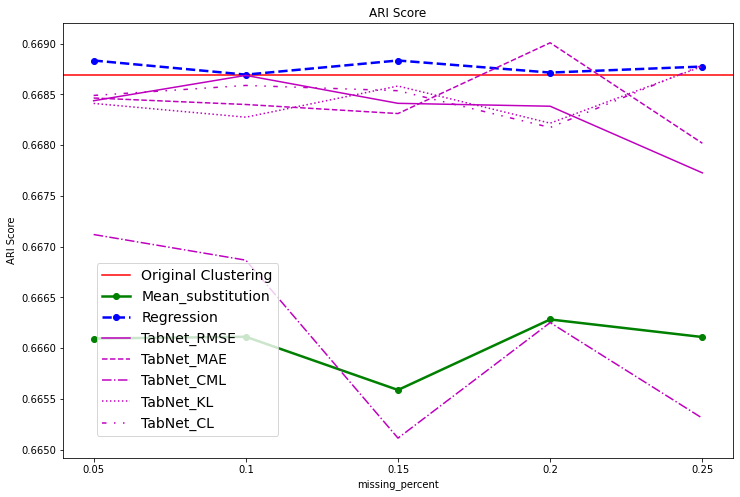

In [44]:
# plot
ari = ARI_score[loss]["TabNet"].copy()

data = {}
for loss in losses:
    data[loss] = {}
    data[loss]["Mean_substitution"] = {k: list(v.values()) for k,v in ARI_score[loss]["Mean_substitution"].items()}
    data[loss]["Regression"] = {k: list(v.values()) for k,v in ARI_score[loss]["Regression"].items()}
    data[loss]["TabNet"] = {k: list(v.values()) for k,v in ARI_score[loss]["TabNet"].items()}

fig, ax = plt.subplots(figsize = (12,8))

plt.axhline(y=ARI_score[loss]['orig_data'], color='r', linestyle='-')


if variable_hyperparams:
    plt.axhline(y=[np.median(x) for x in data[loss]["Mean_substitution"].values()], color='g', linestyle='-', linewidth=2.5)
    plt.axhline(y=[np.median(x) for x in data[loss]["Regression"].values()], color='b', linestyle='--', linewidth=2.5)
else:
    ax.errorbar(x = list(data[loss]["Mean_substitution"].keys()), y = [np.median(x) for x in data[loss]["Mean_substitution"].values()], linestyle='-', color = 'g', linewidth=2.5, fmt='o', capsize=10)
    ax.errorbar(x = list(data[loss]["Regression"].keys()), y = [np.median(x) for x in data[loss]["Regression"].values()],linestyle='--', color = 'b', linewidth=2.5, fmt='o', capsize=10)

ax.errorbar(x = list(data['rmse']["TabNet"].keys()), y = [np.median(x) for x in data['rmse']["TabNet"].values()], linestyle='-', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['mae']["TabNet"].keys()), y = [np.median(x) for x in data['mae']["TabNet"].values()], linestyle='--', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['cml']["TabNet"].keys()), y = [np.median(x) for x in data['cml']["TabNet"].values()], linestyle='-.', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['kl']["TabNet"].keys()), y = [np.median(x) for x in data['kl']["TabNet"].values()], linestyle=':', ecolor='m', color = 'm', linewidth=1.5, capsize=10)
ax.errorbar(x = list(data['cl']["TabNet"].keys()), y = [np.median(x) for x in data['cl']["TabNet"].values()], linestyle=(0, (3, 5, 1, 5, 1, 5)), ecolor='m', color = 'm', linewidth=1.5, capsize=10)


plt.xlabel(config["general"]["experiment_variable"])
plt.ylabel("ARI Score")
plt.title(f"ARI Score")
plt.legend(['Original Clustering', 'Mean_substitution', 'Regression', 'TabNet_RMSE', 'TabNet_MAE', 'TabNet_CML', 'TabNet_KL', 'TabNet_CL'],fontsize=14, loc=(0.05, 0.05))

if save_output:
    plt.savefig(os.path.join(plots_path, "5_ARI-score.png"), **config["plots"])

plt.show()

### RQ 3: Decision Tree
Train decision tree on predicted data (missing values) only. This will reflect the predictions of the model.

In [ ]:
from sklearn import tree

X_dt = X_reconstr["TabNet"][str(best_experiment_value)][best_run][X_mv[best_experiment_value][best_run][experiment_feature].isna()]
y_dt = X_dt[experiment_feature]
X_dt = X_dt.drop(experiment_feature, axis=1)

tree_Regressor = tree.DecisionTreeRegressor()
dt = tree_Regressor.fit(X_dt, y_dt)

In [ ]:
plt.figure(figsize=(30,20))
dt_plot = tree.plot_tree(dt, fontsize=10)

### Save Output

In [ ]:
if save_output:
    # save output file
    with open(output_path, "w") as f:
                toml.dump(output, f)

    # save notebook
    shutil.copy2(nb_name, experiment_path)
    
if save_output or save_models:
    config[experiment_dict_key][config["general"]["experiment_variable"]] = experiment_variable_values
    with open(config_path, "w") as f:
        toml.dump(config, f)

## 6. Old Code

## Distribution of KL Divergence
non-symmetric, here: punishes outliers heavily

d_orig = X[experiment_feature]
d_tab = X_reconstr["TabNet"]['0.25'][2][experiment_feature]
d_heu = X_reconstr["Heuristic"][0.2][2][experiment_feature]
min_val = min(min(d_orig), min(d_tab))
max_val = max(max(d_orig), max(d_tab))

distr_tab = d_tab.plot.kde(ind=list(np.linspace(min_val,max_val,100)), color="m", label="TabNet",legend=True).get_lines()[0].get_ydata() 
distr_tab /= sum(distr_tab)
distr_true = d_orig.plot.kde(ind=list(np.linspace(min_val,max_val,100)), color="gray", label="Original Data",legend=True).get_lines()[1].get_ydata()
distr_true /= sum(distr_true)
distr_heu = d_heu.plot.kde(ind=list(np.linspace(min_val,max_val,100)), color="g", title="Probability density functions", label="Heuristic",legend=True).get_lines()[2].get_ydata()
distr_heu /= sum(distr_heu)
plt.text(5.2, .55, f"KL Divergence\nD (TabNet || Original Data)\n{round(kl_divergence(d_tab, d_orig),4)}\nD (Heuristic || Original Data)\n{round(kl_divergence(d_heu, d_orig),4)}", fontsize = 12, horizontalalignment="right")
if save_output:
    plt.savefig(os.path.join(plots_path, "problem_KL-divergence.png"), **config["plots"], bbox_inches="tight")

In [ ]:
#best_model = all_models[best_experiment_value][best_run]
best_model = all_models[best_experiment_value][best_run]
explain_matrix, masks = best_model.explain(test_data)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(1, 4, figsize=(10,20))

axs[0].imshow(explain_matrix[:])
axs[0].set_title(f"mask_agg",fontsize=16)

for i in range(3):
    axs[i+1].imshow(masks[i][:])
    axs[i+1].set_title(f"mask {i}",fontsize=16)

In [ ]:
best_model.feature_importances_